In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from systole import import_ppg
from systole.detection import oxi_peaks, peak_replacement, artifact_removal
from systole.hrv import time_domain
from adtk.detector import QuantileAD, GeneralizedESDTestAD
from adtk.visualization import plot
from adtk.data import validate_series

Here, we describe the default method used to detect and remove artifacts and outliers in PPG recording. We use the [Anomaly Detection Toolkit](https://arundo-adtk.readthedocs-hosted.com/en/latest/index.html) to detect volatility changes in PPG recording and spikes in R-R time series.

In [22]:
oxi = import_ppg('1')[0, :]

# Find peaks

In [23]:
signal, peaks = oxi_peaks(oxi)

# Remove 3 consecutive beats
#peaks[np.where(peaks)[0][50:53]] = 0

# Remove 2 consecutive beats
#peaks[np.where(peaks)[0][100:101]] = 0

# Store into a Panda DataFrame
rr = np.diff(np.where(peaks))[0]
time = pd.to_datetime(np.cumsum(rr), unit='ms')
df = pd.DataFrame({'rr': rr}, index=time)
df = validate_series(df.rr)

Original time-serie

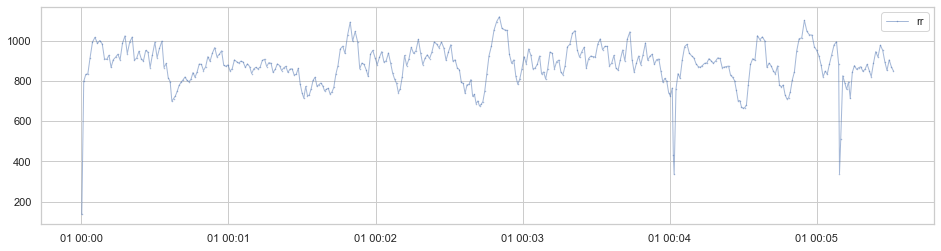

In [24]:
plot(df, ts_linewidth=1);

In [25]:
time_domain(rr)

,Values,Metric
0,872.00,MeanRR
1,70.80,MeanBPM
2,881.50,MedianRR
3,68.07,MedianBPM
4,137.00,MinRR
5,53.67,MinBPM
6,1118.00,MaxRR
7,437.96,MaxBPM
8,105.29,SDNN
9,72.09,RMSSD


# Find outliers

We use quantile detection for to find outliers in the lower bound of the distribution (too short R-R interval, likely created by extra R peaks).

In [26]:
quantile_ad = QuantileAD(low=0.01)
anomalies = quantile_ad.fit_detect(df)

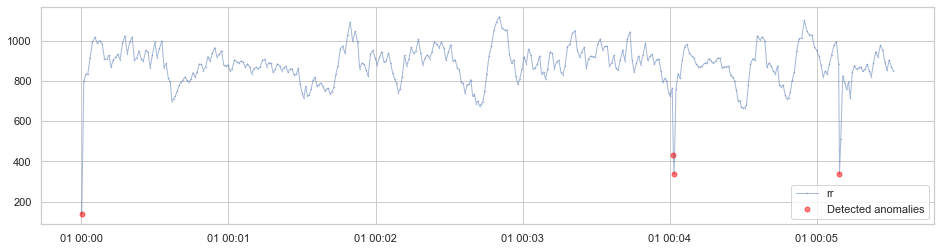

In [27]:
plot(df, anomaly_pred=anomalies, ts_linewidth=1, ap_markersize=5, ap_color='red', ap_marker_on_curve=True);

# Remove outliers

In [28]:
# Remove peqks in booleqn vector
rm_peaks = np.where(peaks)[0][1:][anomalies.values]
peaks[rm_peaks] = 0
new_rr = np.diff(np.where(peaks))[0]

In [29]:
# Create a new DataFrame
time = pd.to_datetime(np.cumsum(new_rr), unit='ms')
df = pd.DataFrame({'rr': new_rr}, index=time)
df = validate_series(df.rr)

R-R time-serie after low outliers removal

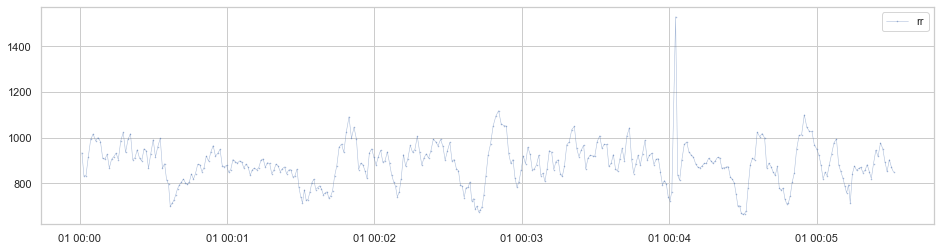

In [30]:
plot(df)

Here, we can see that this procedure also revealed a missing R peaks (at 3:00).

Find outliers in the upper bound (resulting in a missing R peaks). Here, we use a generalized ESD test.

In [31]:
quantile_ad = GeneralizedESDTestAD()
anomalies = quantile_ad.fit_detect(df)

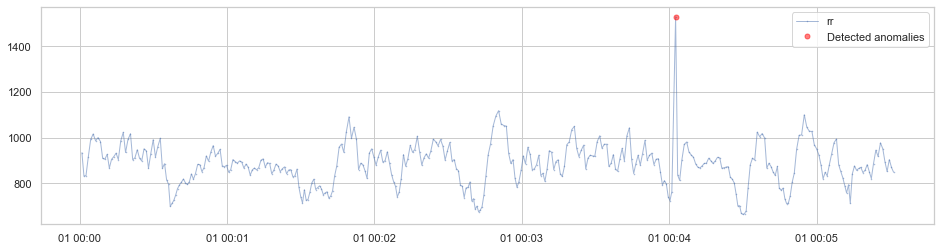

In [32]:
plot(df, anomaly_pred=anomalies, ts_linewidth=1, ap_markersize=5, ap_color='red', ap_marker_on_curve=True);

Here, we will just add a skipe equidistant for the outlying peak and the previous one.

In [33]:
final = []
for outlier in np.where(anomalies.values)[0]:
    new_peaks, npeaks = peak_replacement(peaks, outlier)
    final.append(new_peaks)

In [34]:
for f in final:
    peaks = np.logical_or(peaks, f)

R-R time-serie after outlier correction

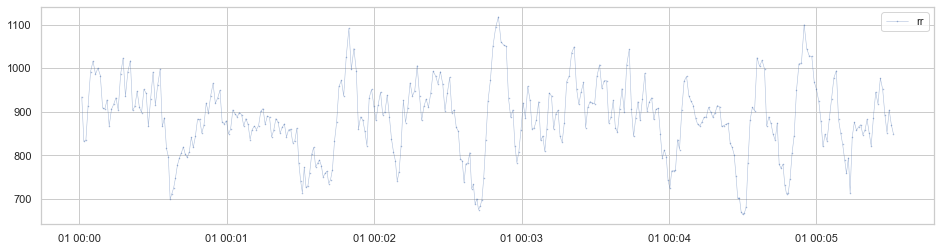

In [35]:
new_rr = np.diff(np.where(peaks))[0]
# Create a new DataFrame
time = pd.to_datetime(np.cumsum(new_rr), unit='ms')
df = pd.DataFrame({'rr': new_rr}, index=time)
df = validate_series(df.rr)
plot(df)

In [36]:
time_domain(new_rr)

,Values,Metric
0,879.00,MeanRR
1,68.94,MeanBPM
2,882.00,MedianRR
3,68.03,MedianBPM
4,664.00,MinRR
5,53.67,MinBPM
6,1118.00,MaxRR
7,90.36,MaxBPM
8,85.67,SDNN
9,46.81,RMSSD


As we can see, a few outliers can affect significantly the estimation of HRV metrics influenced by vagally mediated variability.

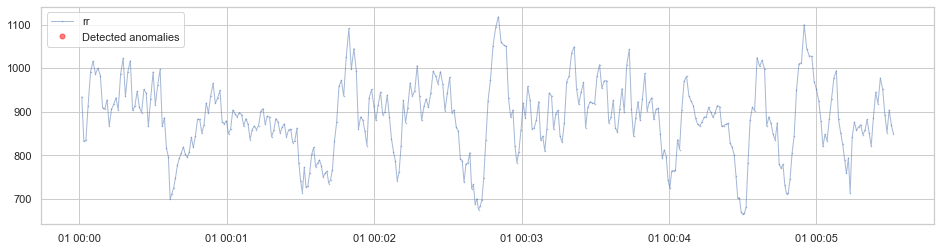

In [37]:
quantile_ad = GeneralizedESDTestAD()
anomalies = quantile_ad.fit_detect(df)
plot(df, anomaly_pred=anomalies, ts_linewidth=1, ap_markersize=5, ap_color='red', ap_marker_on_curve=True);

# Test functions

The procedure prviously describe is implemented in the artifact_removal() function.

## Test with extrabeats

In [41]:
signal, peaks = oxi_peaks(oxi)
time_domain(np.diff(np.where(peaks)[0]))

,Values,Metric
0,872.00,MeanRR
1,70.80,MeanBPM
2,881.50,MedianRR
3,68.07,MedianBPM
4,137.00,MinRR
5,53.67,MinBPM
6,1118.00,MaxRR
7,437.96,MaxBPM
8,105.29,SDNN
9,72.09,RMSSD


In [60]:
rms = []
for i in range(100):
    noisy_peaks = peaks.copy()
    
    # Add extra beats (n=5)
    idx = np.random.choice(np.arange(len(noisy_peaks)), size=5)
    noisy_peaks[idx] = 1
    
    # Apply artifact correction
    clean_peaks, per = artifact_removal(noisy_peaks)
    stats = time_domain(np.diff(np.where(clean_peaks)[0]))
    rms.append(stats.Values[stats.Metric=='RMSSD'].iloc[0])

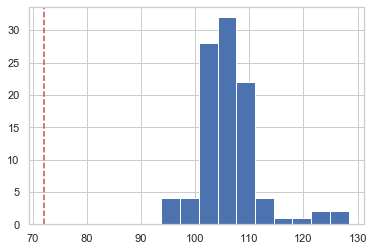

In [67]:
plt.hist(rms)
plt.axvline(x=72.09, color='r', linestyle='--')

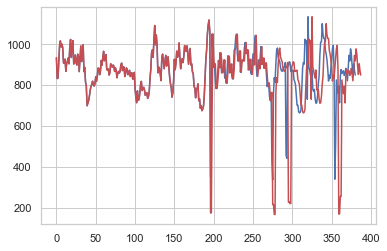

In [71]:
plt.plot(np.diff(np.where(noisy_peaks)[0]))
plt.plot(np.diff(np.where(clean_peaks)[0]), 'r')

In [39]:
new_rr = np.diff(np.where(cleaned_peaks))[0]
# Create a new DataFrame
time = pd.to_datetime(np.cumsum(new_rr), unit='ms')
df = pd.DataFrame({'rr': new_rr}, index=time)
df = validate_series(df.rr)
plot(df)

NameError: name 'cleaned_peaks' is not defined